In [2]:
import cv2
import math
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, SGD

import warnings
warnings.filterwarnings('ignore')

import urllib
import os

!pip install mplcyberpunk
import mplcyberpunk

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import cv2
from google.colab import drive

drive.mount('/content/drive')

input_folder = "/content/drive/MyDrive/data/input/"

output_folder = "/content/drive/MyDrive/data/output/"


face_cascade = cv2.CascadeClassifier("/content/drive/MyDrive/data/haarcascade_frontalface_default.xml")

folders = [folder for folder in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, folder))]

for folder in folders:
    output_subfolder = os.path.join(output_folder, folder)
    os.makedirs(output_subfolder, exist_ok=True)

    folder_path = os.path.join(input_folder, folder)
    image_files = [file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]

    for i, image_file in enumerate(image_files):
        image_path = os.path.join(folder_path, image_file)
        frame = cv2.imread(image_path)

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.5, minNeighbors=5)

        for (x, y, w, h) in faces:
            roi_color = frame[y:y+h, x:x+w]

            image_number = str(i).zfill(3)
            file_name, file_extension = os.path.splitext(image_file)
            output_file = os.path.join(output_subfolder, f"{folder}_{image_number}{file_extension}")

            cv2.imwrite(output_file, roi_color)

cv2.destroyAllWindows()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
Train_dir = pathlib.Path('/content/drive/MyDrive/data/output/')
Test_dir = pathlib.Path('/content/drive/MyDrive/data/output/')
Val_dir = pathlib.Path('/content/drive/MyDrive/data/output/')

image_count_train = len(list(Train_dir.glob('*/*.jpg')))
print("Training Samples ---> ",image_count_train)

image_count_test = len(list(Test_dir.glob('*/*.jpg')))
print("Testing Samples ---> ",image_count_test)

image_count_val = len(list(Val_dir.glob('*/*.jpg')))
print("Testing Samples ---> ",image_count_val)

Training Samples --->  58
Testing Samples --->  58
Testing Samples --->  58


In [6]:
#Defining constants

random_seed=123
batch_size = 32
img_height = 180
img_width = 180

In [7]:
# Training Set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(Train_dir,
                                                               seed=random_seed,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

# Testing Set
test_ds = tf.keras.preprocessing.image_dataset_from_directory(Test_dir,
                                                               seed=random_seed,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

# Validation Set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(Val_dir,
                                                               seed=random_seed,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

Found 58 files belonging to 18 classes.
Found 58 files belonging to 18 classes.
Found 58 files belonging to 18 classes.


In [8]:
# Listing all the classes

class_names = train_ds.class_names
class_map={}
name_class_map={'Besan', 'afnan', 'hassan', 'Tareq', 'shooq', 'sanad', 'hazem', 'anas', 'Omar', 'mohammad', 'marwh', 'ahmad', 'abdulrahman', 'shahadpic', 'HalaF', 'abdulaziz', 'abdulrahmanN', 'mohammadA'}

for i in range(len(class_names)):
    class_map[i]=class_names[i]
class_map

{0: 'Besan',
 1: 'HalaF',
 2: 'Omar',
 3: 'Tareq',
 4: 'abdulaziz',
 5: 'abdulrahman',
 6: 'abdulrahmanN',
 7: 'afnan',
 8: 'ahmad',
 9: 'anas',
 10: 'hassan',
 11: 'hazem',
 12: 'marwh',
 13: 'mohammad',
 14: 'mohammadA',
 15: 'sanad',
 16: 'shahadpic',
 17: 'shooq'}

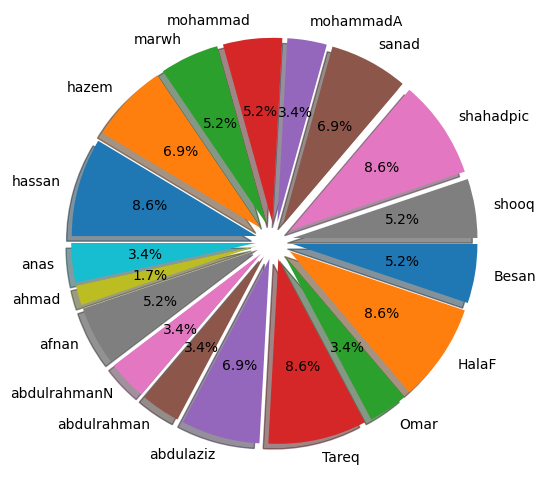

In [9]:
import matplotlib.pyplot as plt

class_count = []
for i in range(len(class_names)):
    class_count.append(len(list(Train_dir.glob('{}/*.jpg'.format(class_names[i])))))

explode = [0.1] * len(class_count)  # Set the same explode value for each class

plt.pie(class_count, shadow=True, startangle=0, explode=explode, autopct='%1.1f%%', counterclock=False, labels=class_names)
plt.show()


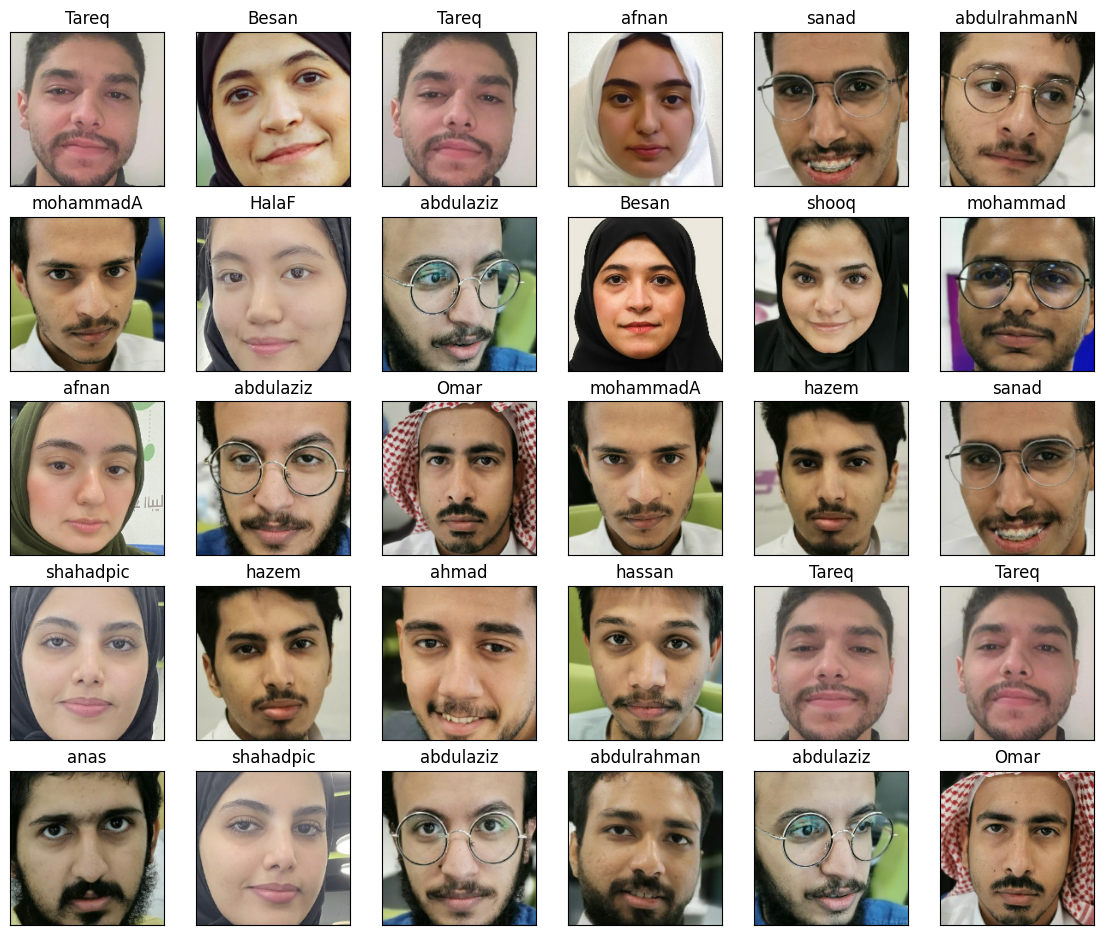

In [10]:
plt.figure(figsize=[14, 14])
for image, label in train_ds.take(1):
    for e, i in enumerate(image):
        if e < 30:
            plt.subplot(6, 6, e+1)
            plt.imshow(i.numpy().astype('uint8'))

            # Access the class name from the class_map dictionary using the label value
            class_name = class_map[label[e].numpy()]
            plt.title(class_name)

            plt.xticks([])
            plt.yticks([])
plt.show()


In [11]:
# Staging the Dataset

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:

# Training the model
face_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(img_height, img_width,3)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, (3, 3), padding="same", activation="relu" ),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu" ),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu" ),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(18, activation='softmax')
])

face_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
             metrics=['accuracy'])

face_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [13]:

chkpt = ModelCheckpoint('checkpoints/best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=0.01)

epochs=25
history_1 = face_model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[es, chkpt])

Epoch 1/25
2/2 [==============================] - ETA: 0s - loss: 2.8943 - accuracy: 0.0345    
Epoch 1: val_loss improved from inf to 2.71584, saving model to checkpoints/best_model.h5
2/2 [==============================] - 9s 5s/step - loss: 2.8943 - accuracy: 0.0345 - val_loss: 2.7158 - val_accuracy: 0.0862
Epoch 2/25
2/2 [==============================] - ETA: 0s - loss: 2.6855 - accuracy: 0.1897
Epoch 2: val_loss improved from 2.71584 to 2.45446, saving model to checkpoints/best_model.h5
2/2 [==============================] - 8s 6s/step - loss: 2.6855 - accuracy: 0.1897 - val_loss: 2.4545 - val_accuracy: 0.4138
Epoch 3/25
2/2 [==============================] - ETA: 0s - loss: 2.3693 - accuracy: 0.4655
Epoch 3: val_loss improved from 2.45446 to 1.95017, saving model to checkpoints/best_model.h5
2/2 [==============================] - 5s 3s/step - loss: 2.3693 - accuracy: 0.4655 - val_loss: 1.9502 - val_accuracy: 0.5862
Epoch 4/25
2/2 [==============================] - ETA: 0s - loss

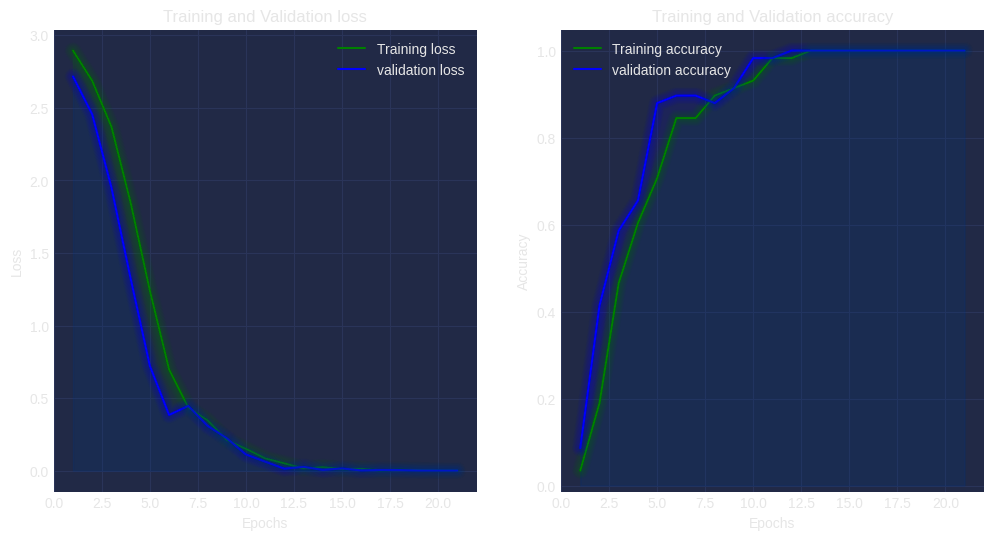

In [14]:
#Visualising model performance
acc_train = history_1.history['accuracy']
acc_val = history_1.history['val_accuracy']

loss_train = history_1.history['loss']
loss_val = history_1.history['val_loss']

epochs = range(1,len(loss_train)+1)
plt.figure(figsize=(12, 6))
plt.style.use('cyberpunk')
plt.subplot(1,2,1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
mplcyberpunk.add_glow_effects()

plt.subplot(1,2,2)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
mplcyberpunk.add_glow_effects()
plt.show()

In [15]:
# saving the model
face_model.save('faces_model.h5')

In [16]:
# Loading the saved model from checkpoint

faces_model = tf.keras.models.load_model('faces_model.h5')
faces_model

In [17]:
faces_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

1/1 [==============================] - 0s 35ms/step


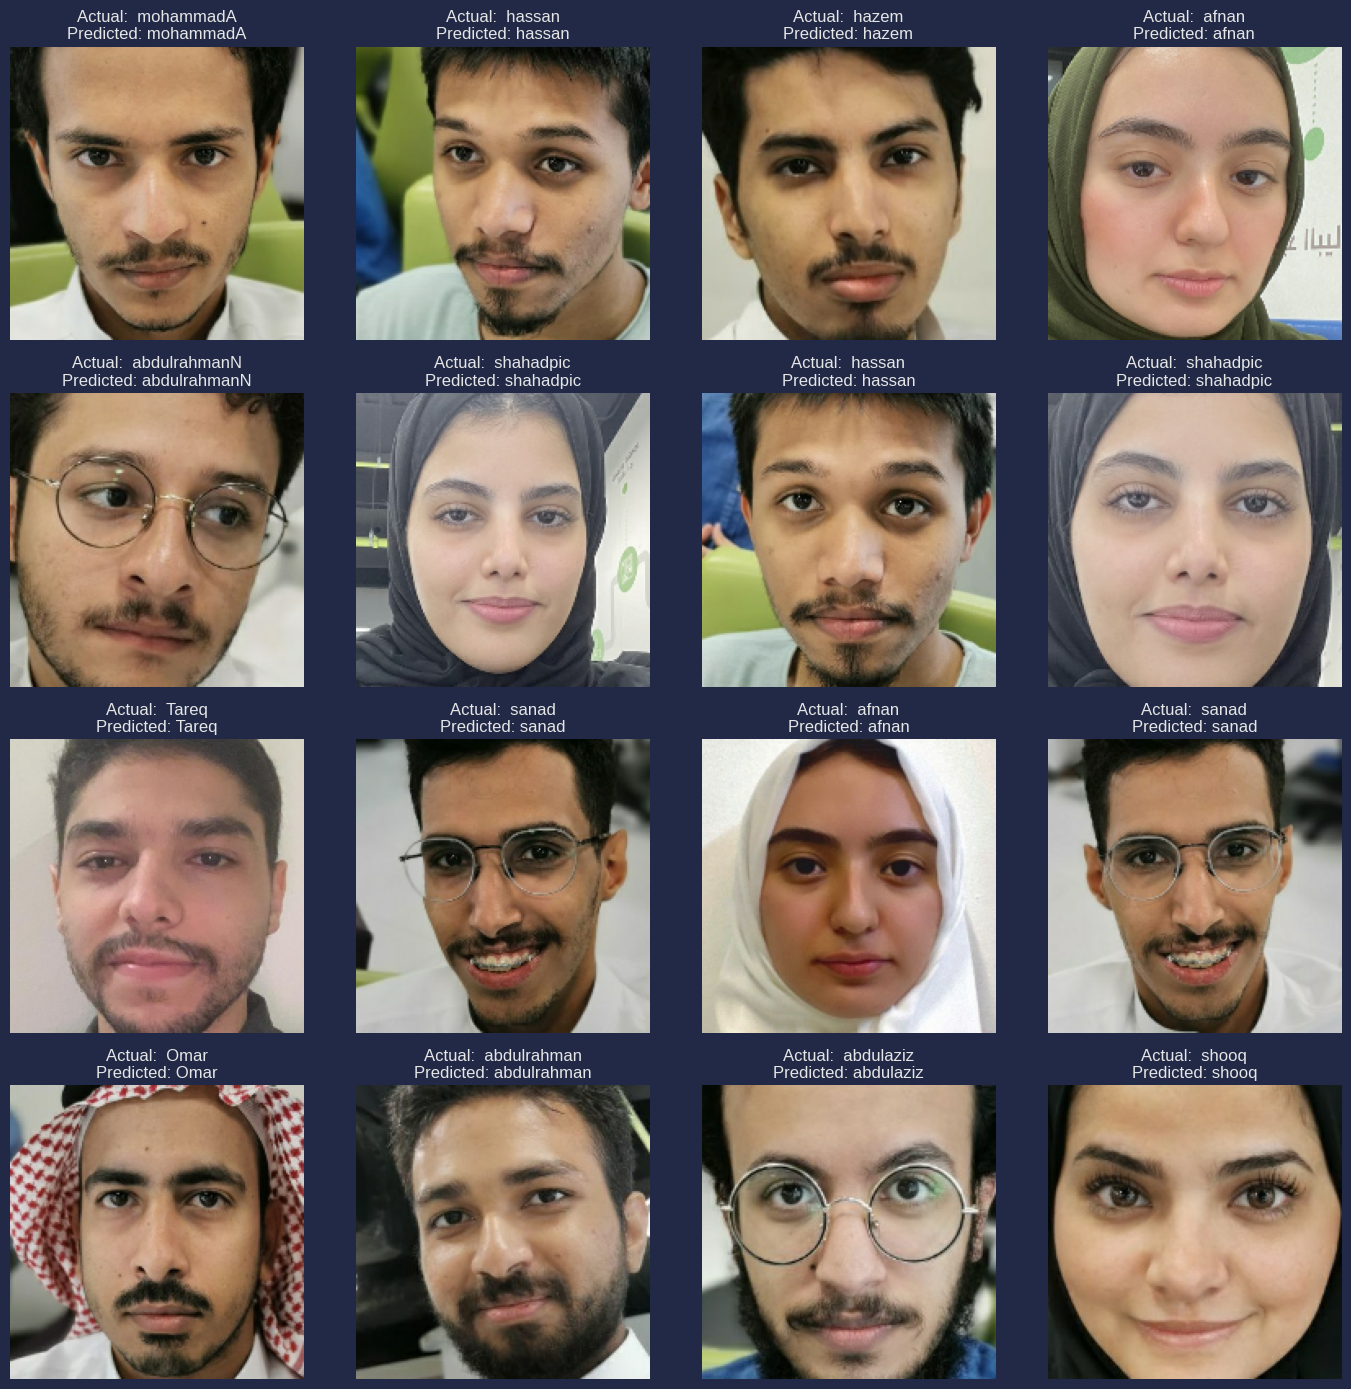

In [18]:
#Visualising a batch of image dataset

test_batch = [(x, y) for (x,y) in val_ds.take(1)] # loading 1 batch of data
image, label = test_batch[0][0], test_batch[0][1]

prediction = faces_model.predict(image)
prediction = np.argmax(prediction, axis=1)


plt.figure(figsize=[14,14])
for e in range(16):
    plt.subplot(4,4,e+1)
    plt.imshow(image[e].numpy().astype('uint8'))
    actual_label = class_map[label[e].numpy()]
    prediction = faces_model.predict(np.expand_dims(image[e], axis=0))
    predicted_label =class_map[np.argmax(prediction)]
    #predicted_label = np.argmax(saved_model.predict(image))
    plt.title('Actual:  {}\nPredicted: {}'.format(actual_label, predicted_label))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [21]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import numpy as np
!pip install opencv-python==4.8.0
img_height = 180
img_width = 180
class_map = {0: 'Besan',
 1: 'HalaF',
 2: 'Omar',
 3: 'Tareq',
 4: 'abdulaziz',
 5: 'abdulrahman',
 6: 'abdulrahmanN',
 7: 'afnan',
 8: 'ahmad',
 9: 'anas',
 10: 'hassan',
 11: 'hazem',
 12: 'marwh',
 13: 'mohammad',
 14: 'mohammadA',
 15: 'sanad',
 16: 'shahadpic',
 17: 'shooq'}
# Load the pre-trained face cascade classifier
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Load the trained face recognition model
face_model = load_model('faces_model.h5')

# Define a function for real-time face recognition
def real_time_face_recognition():
    video_capture = cv2.VideoCapture(0)

    while True:
        # Capture frame-by-frame
        ret, frame = video_capture.read()

        # Convert the frame to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect faces in the grayscale image
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.5, minNeighbors=5)

        for (x, y, w, h) in faces:
            # Extract the region of interest (ROI) from the original frame
            roi_color = frame[y:y+h, x:x+w]

            # Preprocess the ROI for face recognition
            resized_roi = cv2.resize(roi_color, (img_width, img_height))
            expanded_frame = np.expand_dims(resized_roi, axis=0)

            image_float = np.array(expanded_frame, dtype=np.float32)


            image_normalized = (image_float - np.min(image_float)) / (np.max(image_float) - np.min(image_float))
            image_normalized *= 255.0

            # Make predictions using the face recognition model
            print(image_normalized)

            predictions = face_model.predict(image_normalized)
            predicted_label =class_map[np.argmax(predictions)]

            # Draw a rectangle and label around the face
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(frame, predicted_label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # Display the resulting frame
        cv2.imshow('Real-Time Face Recognition', frame)

        # Exit the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the video capture and close all windows
    video_capture.release()
    cv2.destroyAllWindows()

# Run the real-time face recognition function
real_time_face_recognition()


ERROR: Could not find a version that satisfies the requirement opencv-python==4.8.0 (from versions: 3.4.0.14, 3.4.10.37, 3.4.11.39, 3.4.11.41, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4.15.55, 3.4.16.57, 3.4.16.59, 3.4.17.61, 3.4.17.63, 3.4.18.65, 4.3.0.38, 4.4.0.40, 4.4.0.42, 4.4.0.44, 4.4.0.46, 4.5.1.48, 4.5.3.56, 4.5.4.58, 4.5.4.60, 4.5.5.62, 4.5.5.64, 4.6.0.66, 4.7.0.68, 4.7.0.72, 4.8.0.74)
ERROR: No matching distribution found for opencv-python==4.8.0


error: ignored